# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
# Підключення Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Імпорт бібліотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Mounted at /content/drive


In [3]:
import pandas as pd

# Шлях до файлу
file_path = '/content/drive/My Drive/bikes_rent.csv'

# Завантаження даних у DataFrame
df = pd.read_csv(file_path)

# Виведення перших 5 рядків
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


In [4]:
# Опис датасету
print(df.info())

# Перевірка статистичних даних
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB
None
           season          yr        mnth     holiday     weekday  workingday  \
count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
me

In [33]:
# Шлях для збереження файлу на Google Drive
output_path = '/content/drive/My Drive/processed_bikes_rent.csv'

# Збереження датасету
df.to_csv(output_path, index=False)

print(f"Файл збережено за адресою: {output_path}")

Файл збережено за адресою: /content/drive/My Drive/processed_bikes_rent.csv


In [37]:
import pandas as pd

# Шлях до файлу
file_path = '/content/drive/My Drive/bikes_rent.csv'

# Зчитування файлу
df = pd.read_csv(file_path)

# Перегляд перших рядків
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


In [38]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/

OverfittingHomeWork.ipynb  Untitled0.ipynb  Untitled1.ipynb


In [5]:
df.drop(columns=['windspeed(ms)'], inplace=True)

In [6]:
print(df['season'].unique())  # Вивести унікальні значення
print(df['holiday'].value_counts())  # Розподіл значень


[1 2 3 4]
holiday
0    710
1     21
Name: count, dtype: int64


In [7]:
print(df.corr()['cnt'].sort_values(ascending=False))

cnt               1.000000
atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
weathersit       -0.297391
Name: cnt, dtype: float64


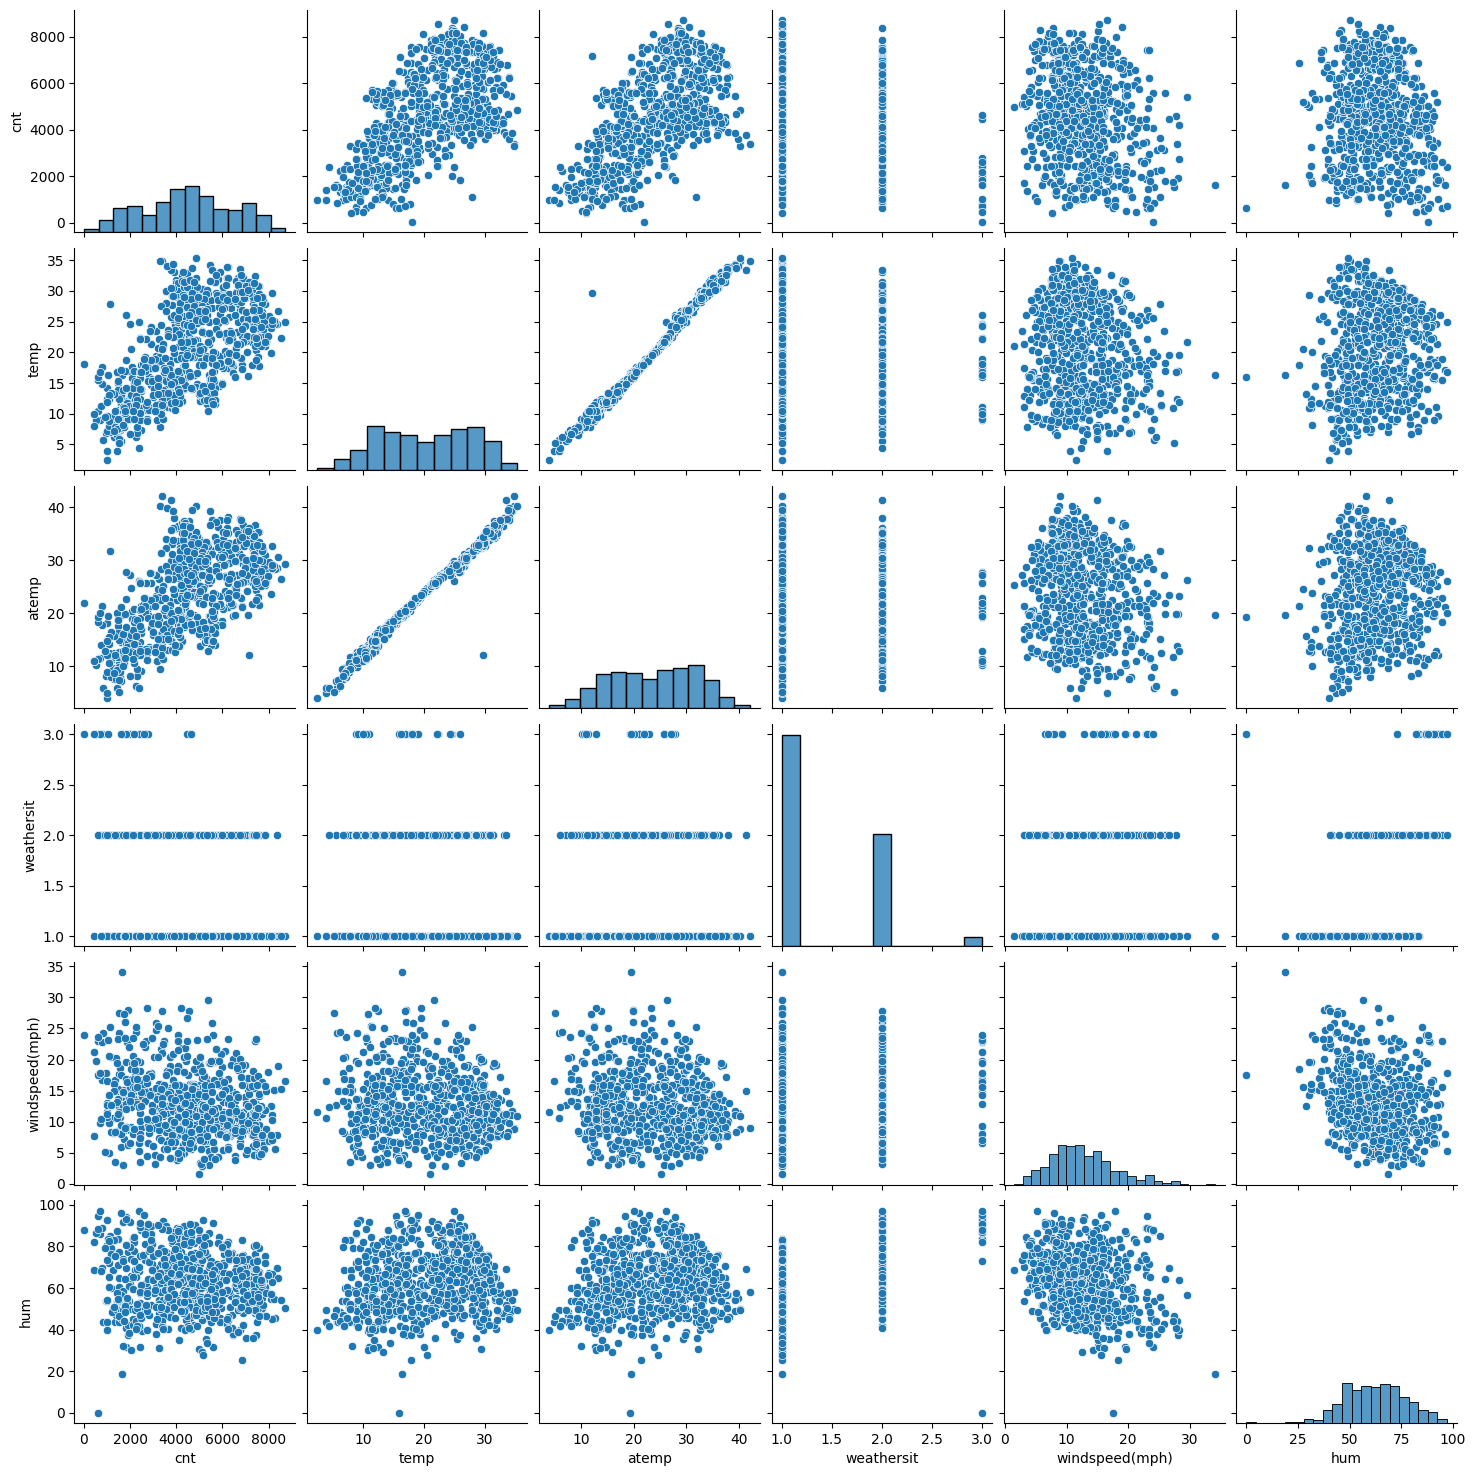

In [8]:
import seaborn as sns
sns.pairplot(df[['cnt', 'temp', 'atemp', 'weathersit', 'windspeed(mph)', 'hum']])
plt.show()

In [9]:
df.drop(columns=['atemp'], inplace=True)  # Або 'temp', якщо ви залишаєте 'atemp'

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [11]:
import pandas as pd

# Завантаження датасету
file_path = '/content/drive/My Drive/bikes_rent.csv'
df = pd.read_csv(file_path)

# Перевірка перших 5 рядків
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

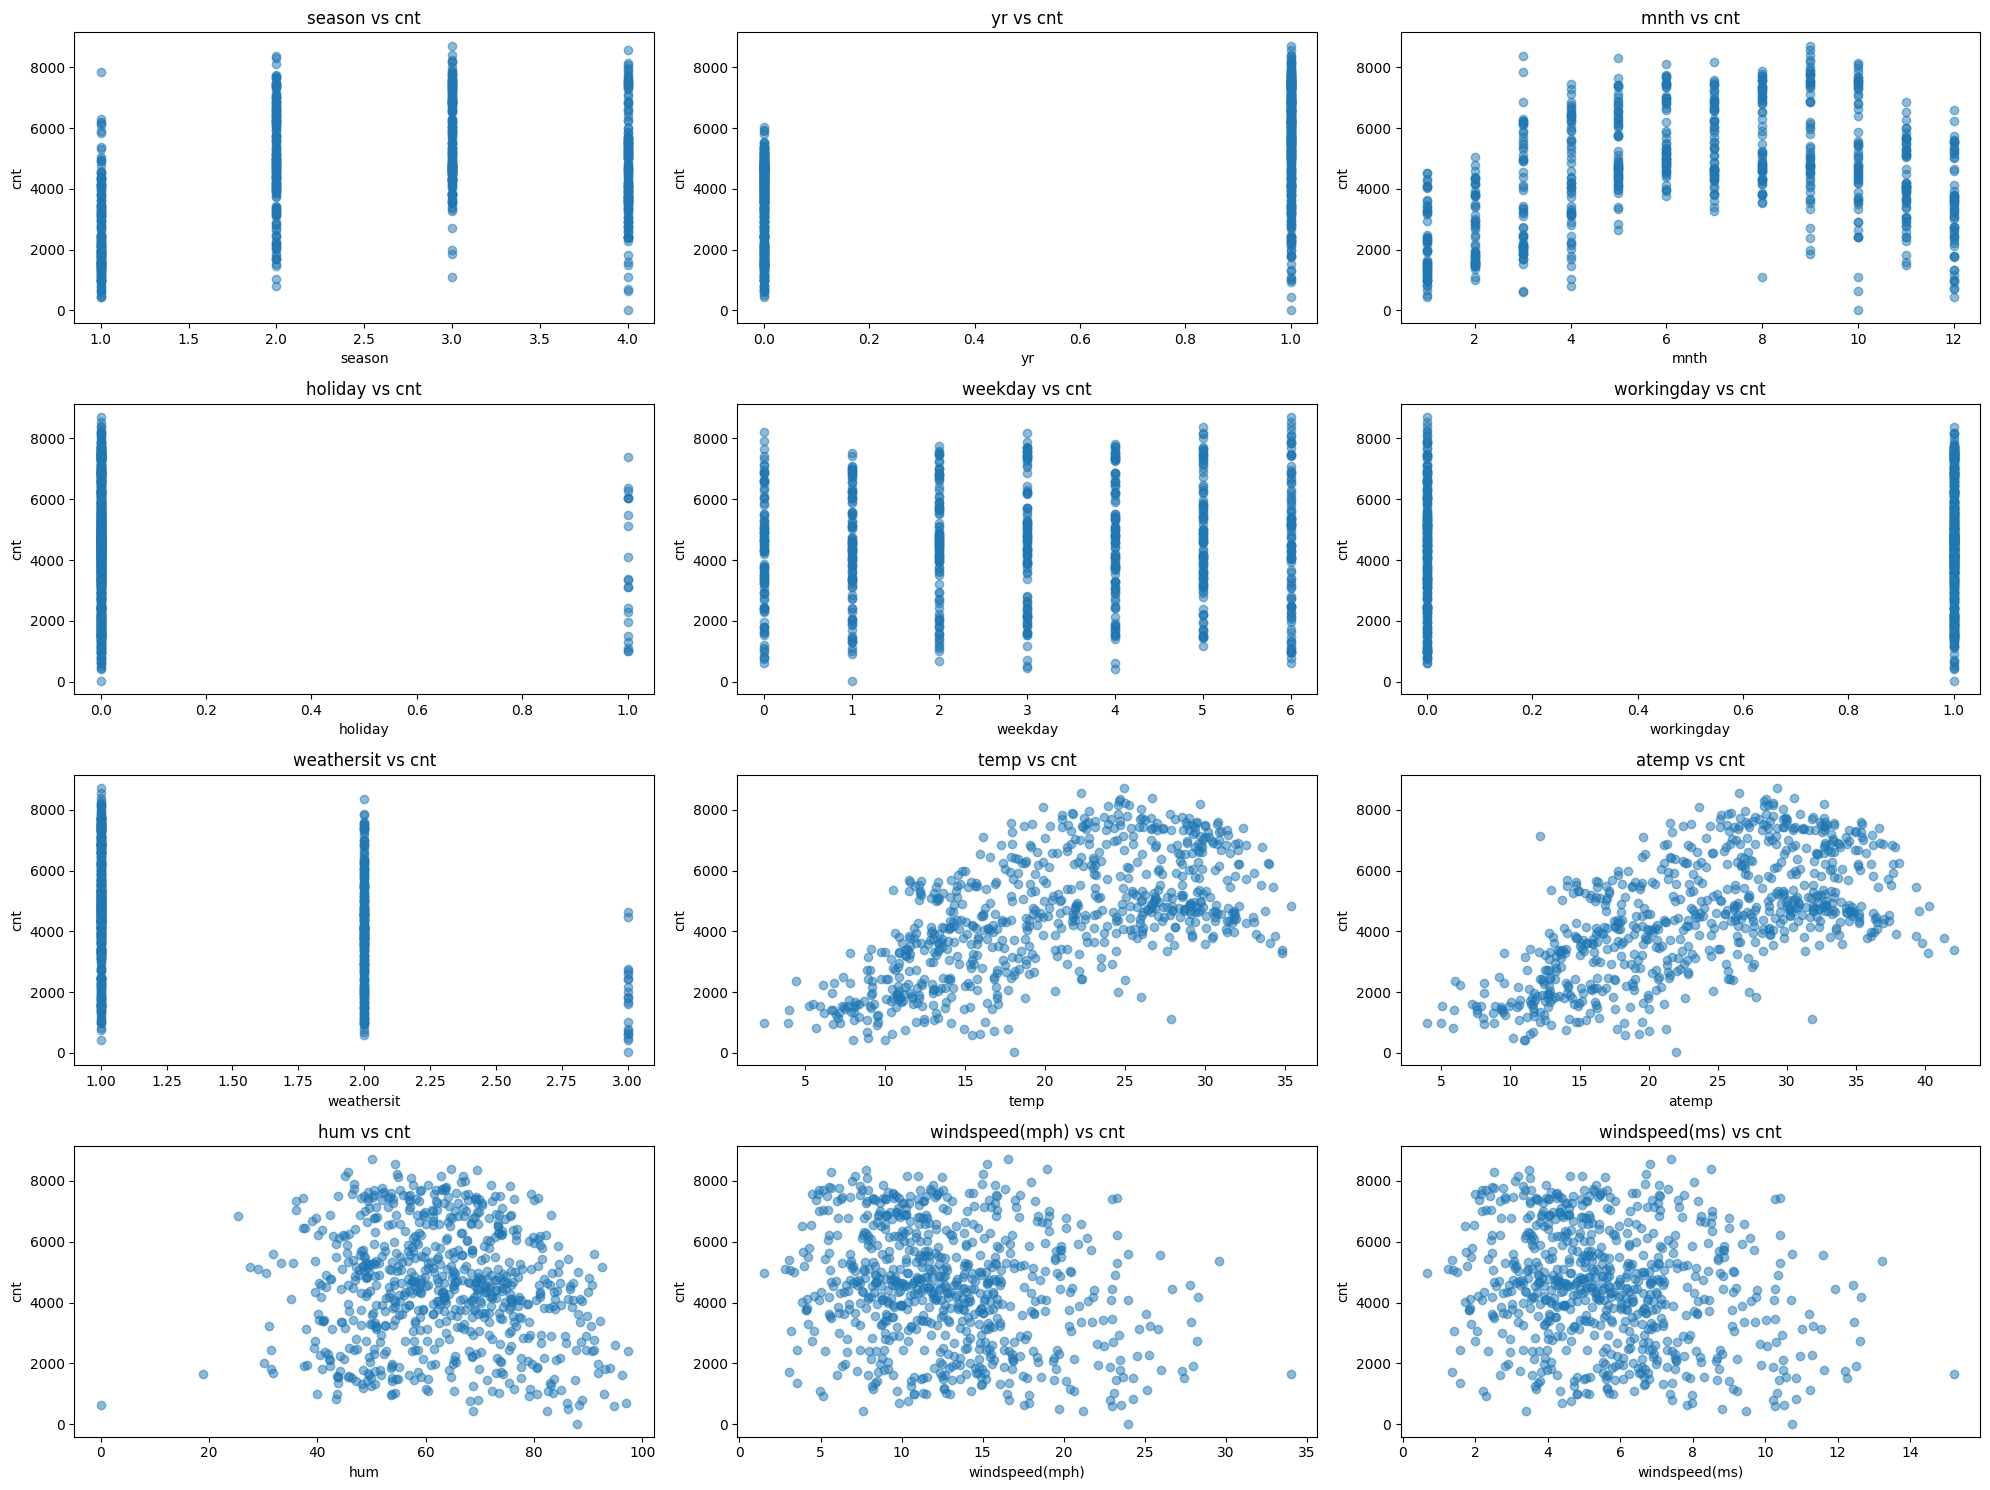

In [12]:
import matplotlib.pyplot as plt

# Список атрибутів для побудови графіків
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
              'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Побудова графіків
plt.figure(figsize=(20, 15))
for i, attr in enumerate(attributes):
    plt.subplot(4, 3, i + 1)
    plt.scatter(df[attr], df['cnt'], alpha=0.5)
    plt.title(f'{attr} vs cnt')
    plt.xlabel(attr)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? Залежність має сезонний характер:
Улітку (червень, липень, серпень) кількість прокатів найбільша.
Узимку кількість прокатів найнижча.
Це пояснюється сприятливими погодними умовами влітку порівняно із зимою.
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно. Температура (temp) і відчутна температура (atemp) мають майже лінійну залежність від cnt.
Чим вища температура, тим більше прокатів.
Це підтверджується високими кореляційними значеннями (0.63 і 0.62 відповідно).


## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [13]:
# Обчислення кореляції всіх ознак із 'cnt'
correlations = df.corrwith(df['cnt'])

# Виведення результатів
print("Кореляції всіх ознак із 'cnt':")
print(correlations.sort_values(ascending=False))

Кореляції всіх ознак із 'cnt':
cnt               1.000000
atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [14]:
# Вибір ознак для аналізу
features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислення попарної кореляції
correlation_matrix = df[features].corr()

# Виведення кореляційної матриці
print("Попарна кореляція між обраними ознаками:")
print(correlation_matrix)

Попарна кореляція між обраними ознаками:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [15]:
# Виведення середніх значень ознак
print("Середні значення ознак:")
print(df.mean())

Середні значення ознак:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [16]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [17]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [18]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [19]:
from sklearn.linear_model import LinearRegression

# Створення об'єкта лінійного регресора
model = LinearRegression()

# Навчання моделі
model.fit(X, y)

# Отримання ваг (coef_) моделі
feature_names = df.columns[:-1]  # Назви ознак (усі, крім 'cnt')
weights = model.coef_  # Ваги ознак

# Виведення ваг ознак
print("Ваги моделі (Linear Regression):")
for name, weight in zip(feature_names, weights):
    print(f"{name}: {weight}")

Ваги моделі (Linear Regression):
season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [20]:
from sklearn.linear_model import Lasso

# Створення об'єкта Lasso-регресора
lasso_model = Lasso(alpha=1.0, random_state=42)  # alpha - параметр регуляризації

# Навчання моделі
lasso_model.fit(X, y)

# Отримання ваг
lasso_weights = lasso_model.coef_

# Виведення ваг
print("Ваги моделі Lasso (L1-регуляризація):")
for name, weight in zip(feature_names, lasso_weights):
    print(f"{name}: {weight}")

Ваги моделі Lasso (L1-регуляризація):
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [21]:
from sklearn.linear_model import Ridge

# Створення об'єкта Ridge-регресора
ridge_model = Ridge(alpha=1.0, random_state=42)  # alpha - параметр регуляризації

# Навчання моделі
ridge_model.fit(X, y)

# Отримання ваг
ridge_weights = ridge_model.coef_

# Виведення ваг
print("\nВаги моделі Ridge (L2-регуляризація):")
for name, weight in zip(feature_names, ridge_weights):
    print(f"{name}: {weight}")


Ваги моделі Ridge (L2-регуляризація):
season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [22]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt

# Масив значень alpha
alphas = np.arange(1, 500, 50)

# Списки для збереження ваг
coefs_lasso = []
coefs_ridge = []

# Обчислення ваг для кожного alpha
for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Ridge
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Конвертація списків у numpy array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

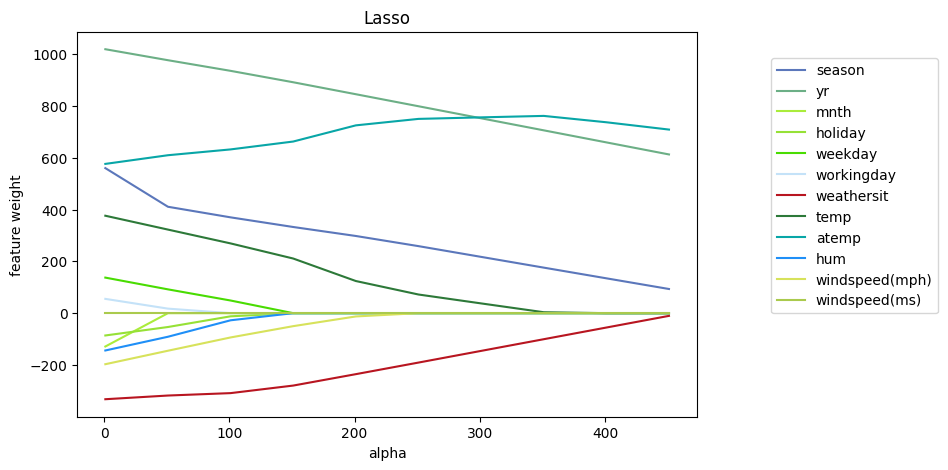

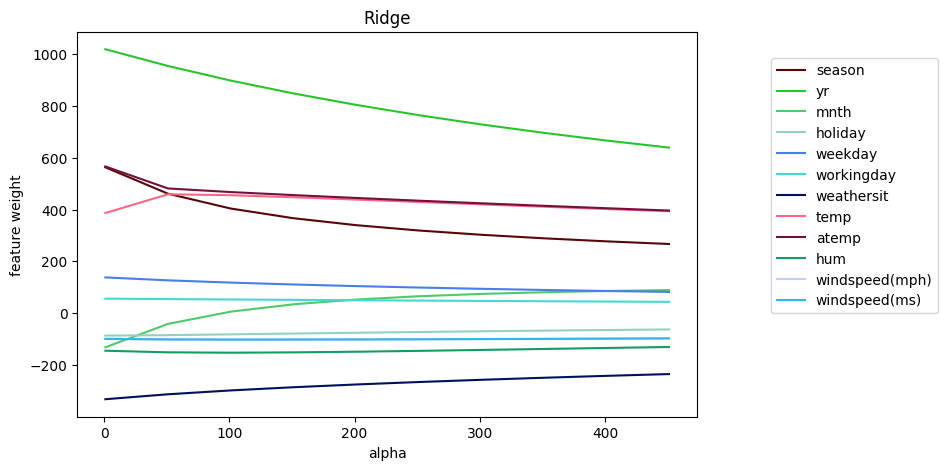

In [23]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha? Lasso (L1-регуляризація) агресивніше зменшує ваги. Деякі з них стають рівними нулю вже при відносно малих значеннях alpha.
Ridge (L2-регуляризація) поступово зменшує ваги, але вони не обнуляються.
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається. Всі ваги наближаються до нуля. Це відбувається тому, що Lasso обнуляє ваги для ознак, які мають менший вплив, щоб мінімізувати функцію втрат.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$. Lasso: Так, для alpha > 0, Lasso обнулює одну з ознак windspeed(ms) або windspeed(mph), оскільки вони дублюють одна одну.
Ridge: Ні, Ridge не виключає ознаки. Він лише зменшує їх ваги, але вони залишаються ненульовими.
1. Який із регуляризаторів підійде для відбору неінформативних ознак? Lasso (L1-регуляризація) підходить краще, оскільки вона обнуляє ваги менш значущих ознак, виключаючи їх із моделі.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

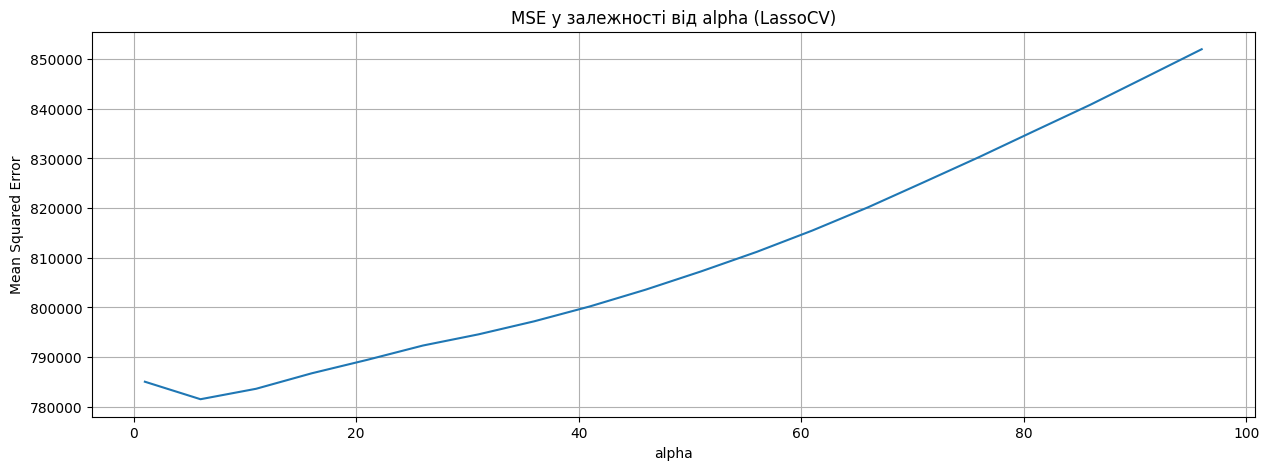

In [27]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)
    x, y = zip(*data)
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

# Дані для графіка
mse_data = list(zip(lasso_cv.alphas_, mse_means))

# Побудова графіка
create_plot(
    mse_data,
    title="MSE у залежності від alpha (LassoCV)",
    xlabel="alpha",
    ylabel="Mean Squared Error",
)

In [25]:
from sklearn.linear_model import LassoCV
import numpy as np
import matplotlib.pyplot as plt

# Масив значень alpha
alphas = np.arange(1, 100, 5)

# Створення LassoCV-регресора
lasso_cv = LassoCV(alphas=alphas, cv=3, random_state=42)

# Навчання регресора
lasso_cv.fit(X, y)

# Отримання середнього MSE для кожного alpha
mse_means = np.mean(lasso_cv.mse_path_, axis=1)

# Виведення найкращого alpha
print("Найкраще alpha:", lasso_cv.alpha_)

Найкраще alpha: 6


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE on each split:
Split 1: Alpha = 6, MSE = 733725.7604052249
Split 2: Alpha = 1, MSE = 799433.1673691692
Split 3: Alpha = 51, MSE = 796979.8955193626


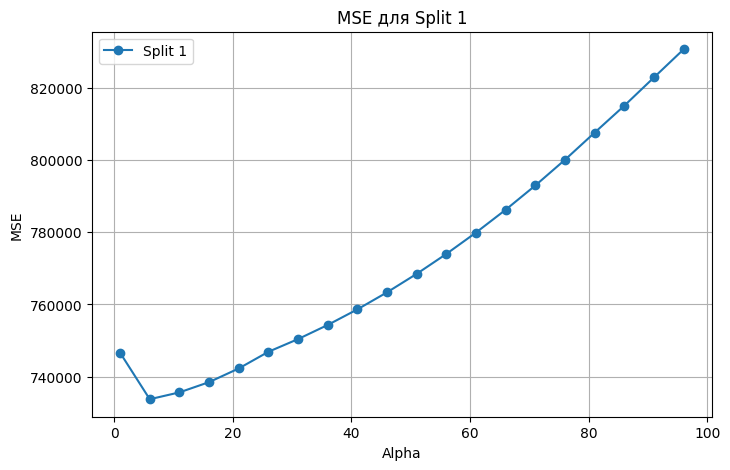

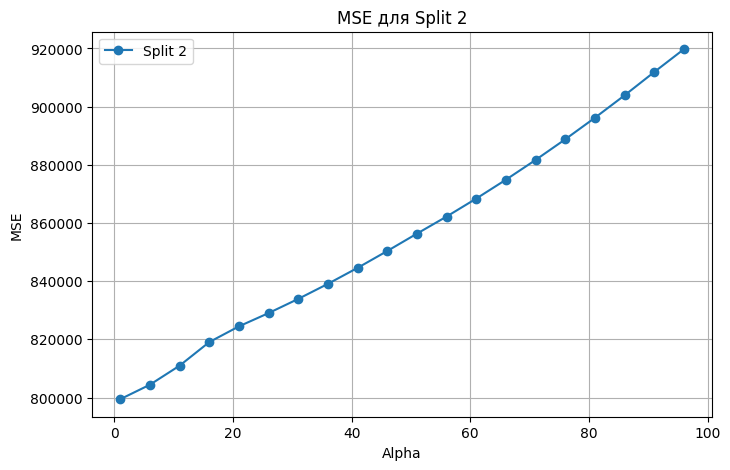

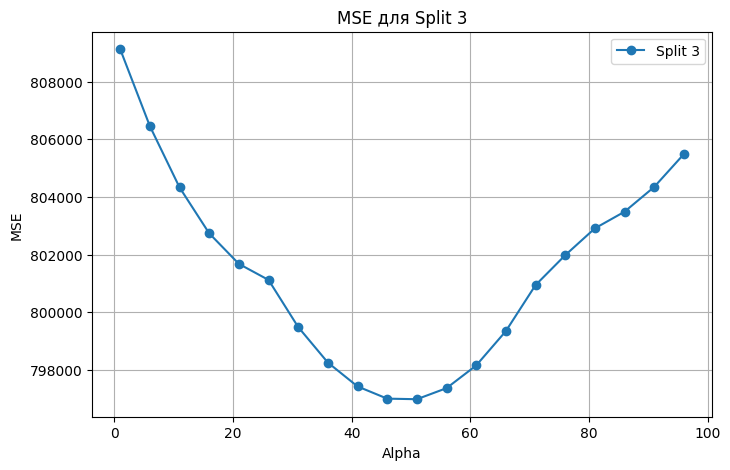

In [28]:
# Визначення мінімумів MSE для кожного розбиття
alphas_with_min_mse = [
    (lasso_cv.alphas_[np.argmin(lasso_cv.mse_path_[:, i])], np.min(lasso_cv.mse_path_[:, i]))
    for i in range(lasso_cv.mse_path_.shape[1])
]

# Виведення значень alpha і відповідних MSE для кожного розбиття
print("Alphas with minimum MSE on each split:")
for i, (alpha, mse) in enumerate(alphas_with_min_mse):
    print(f"Split {i + 1}: Alpha = {alpha}, MSE = {mse}")
# Побудова графіків
for i in range(lasso_cv.mse_path_.shape[1]):
    plt.figure(figsize=(8, 5))
    plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_[:, i], marker="o", label=f"Split {i + 1}")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.title(f"MSE для Split {i + 1}")
    plt.legend()
    plt.grid()
    plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__Ознаки з великими позитивними коефіцієнтами, ймовірно:

temp (температура).
atemp (відчутна температура).
yr (рік).
season (сезон).

In [29]:
# Отримання ознак із найбільшими позитивними коефіцієнтами
top_positive_features = sorted(
    zip(feature_names, lasso_cv.coef_), key=lambda x: -x[1]
)[:4]

print("4 ознаки з найбільшими позитивними коефіцієнтами:")
for feature, coef in top_positive_features:
    print(f"{feature}: {coef}")# ???

4 ознаки з найбільшими позитивними коефіцієнтами:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535
temp: 370.67985503003405


#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__Найбільші за модулем негативні коефіцієнти, ймовірно:

weathersit (погодні умови).
windspeed(mph) (швидкість вітру).
hum (вологість).
Аналіз залежностей cnt від цих ознак:

Графіки показують зменшення кількості прокатів при збільшенні цих змінних.
Логічно, що:
Сильний вітер, висока вологість і несприятливі погодні умови (дощ, туман) зменшують активність.


In [31]:
# Вибір найбільших за модулем **негативних коефіцієнтів**
top_negative_features = sorted(
    [(feature, coef) for feature, coef in zip(feature_names, lasso_cv.coef_) if coef < 0],
    key=lambda x: abs(x[1]),
    reverse=True
)[:3]

print("3 ознаки з найбільшими за модулем негативними коефіцієнтами:")
for feature, coef in top_negative_features:
    print(f"{feature}: {coef}")

3 ознаки з найбільшими за модулем негативними коефіцієнтами:
weathersit: -330.5598567399817
windspeed(mph): -191.77140847135036
hum: -140.00740550068844


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__Ознаки, які виключені з моделі (близькі до нуля), можуть бути:

windspeed(ms) (через дублювання windspeed(mph)).
Інші ознаки, які мають низьку кореляцію з cnt.
Чому модель їх виключила?

Вони не мають значущого впливу на попит.
Дублюючі ознаки (windspeed(ms)).
Чи правда, що вони не впливають на попит?

Так, за результатами регуляризації та кореляції.

In [32]:
# Отримання ознак із коефіцієнтами, близькими до нуля
near_zero_features = [(feature, coef) for feature, coef in zip(feature_names, lasso_cv.coef_) if abs(coef) < 1e-3]

print("Ознаки з коефіцієнтами, близькими до нуля:")
for feature, coef in near_zero_features:
    print(f"{feature}: {coef}")

Ознаки з коефіцієнтами, близькими до нуля:
windspeed(ms): -2.6854702314758792e-08


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.